In [ ]:
%autosave 0

### Kaggle - Web Traffic Time Series Forecasting

## Model 07 - Neural Network with Fibonacci 

### v1.2 Predict for stage 1

by Louis Yang

Use Fibonacci series median instead of median

Split into groups based on the scale of visit number and train individual model in each group

Prediction from "model_7_CNN_with_Fibo_1_range_correct_1_smape_correct"

In [162]:
model_name = 'model_7_CNN_with_Fibo_1_range_correct_2_predict'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [4]:
def arr_info(arr_list):
    print('shape, min, max, median, stdev')
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [5]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


In [9]:
input_df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09     ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0     ...            32.0        63.0        15.0        26.0   
1        10.0     ...            17.0        42.0        28.0        15.0   
2         4.0     ...             3.0         1.0         1.0         7.0   
3        11.0     ...            32.0        10.0        26.0        27.0   
4         NaN     ...            48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [10]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [11]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

input_data = input_df[input_df_dates].values; input_data

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [12]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [13]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [14]:
test_length = 0  # for predicting
#test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [15]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; X_input_dates

Index(['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05',
       '2015-11-06', '2015-11-07', '2015-11-08', '2015-11-09', '2015-11-10',
       '2015-11-11', '2015-11-12', '2015-11-13', '2015-11-14', '2015-11-15',
       '2015-11-16', '2015-11-17', '2015-11-18', '2015-11-19', '2015-11-20',
       '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25',
       '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
       '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05',
       '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10',
       '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15',
       '2015-12-16', '2015-12-17', '2015-12-18', '2015-12-19', '2015-12-20',
       '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
       '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29', '2015-12-30',
       '2015-12-31', '2016-01-01', '2016-01-02'],
      dtype='object')

In [16]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-11-01', '2016-01-02')

In [17]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [18]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
X_output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [19]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-10-30', '2016-12-31')

In [20]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [21]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

#### Y

In [22]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; Y_input_dates

Index(['2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
       '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
       '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17',
       '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
       '2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27',
       '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
       '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05', '2016-02-06',
       '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11',
       '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16',
       '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
       '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25', '2016-02-26',
       '2016-02-27', '2016-02-28', '2016-02-29', '2016-03-01', '2016-03-02',
       '2016-03-03', '2016-03-04', '2016-03-05'],
      dtype='object')

In [23]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-01-03', '2016-03-05')

In [24]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [25]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-01-01'
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [26]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-01-01', '2017-03-04')

In [27]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [28]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

## Fibonacci

In this testing code, we should not include the last y_length days since in the real predicting stage, we don't know their visits.

Here, we don't distinguish between input and output fib_dates.

In [29]:
if test_length:
    fib_dates = input_df_dates[:-test_length]
else:
    fib_dates = input_df_dates
fib_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [30]:
fib_data = input_df[fib_dates].values; fib_data

array([[ 18.,  11.,   5., ...,  19.,  18.,  20.],
       [ 11.,  14.,  15., ...,  45.,  26.,  20.],
       [  1.,   0.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Find starting dates

Not using this. Use numpy nan method instead

start_tf = ~np.isnan(fib_data); start_tf

fib_days = len(fib_data[0]); fib_days

index_range = np.arange(fib_days)
def first_true_index(x):
    temp = index_range[x]
    if temp.any():
        return temp[0]
    else:
        return -1
#first_true_index_v = np.vectorize(first_true_index)

start_index = np.array([first_true_index(x) for x in start_tf])

start_index

### Window

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [31]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [32]:
fib_view_list = [fib_data[:, -w:] for w in windows]

In [33]:
fib_median_list = np.array([np.nanmedian(view, axis=-1) 
                            for view in fib_view_list])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [34]:
fib_median_list.T.shape

(145063, 8)

In [35]:
fib_median_na = np.nanmedian(fib_median_list.T, axis=-1)

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [36]:
fib_median_na

array([ 18.25,  21.5 ,   4.  , ...,    nan,    nan,    nan])

In [37]:
fib_median = np.nan_to_num(fib_median_na); fib_median.shape

(145063,)

In [38]:
fib_median

array([ 18.25,  21.5 ,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

In [39]:
X_input_first_day, Y_input_final_day

('2015-11-01', '2016-03-05')

input_data contains X_input and Y_input array

In [40]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates

Index(['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05',
       '2015-11-06', '2015-11-07', '2015-11-08', '2015-11-09', '2015-11-10',
       ...
       '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
       '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05'],
      dtype='object', length=126)

In [41]:
input_data = input_df[input_dates].values; input_data

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [42]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [43]:
input_data_num.shape

(145063, 126)

### Output Data

In [44]:
X_output_first_day, X_output_final_day, Y_output_final_day

('2016-10-30', '2016-12-31', '2017-03-04')

output_data for this self-testing script contains both X_output and Y_output

In [45]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [46]:
output_dates.shape

(63,)

In [47]:
output_data = input_df[output_dates].values; output_data

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [48]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [49]:
output_data_num.shape

(145063, 63)

### View

In [50]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [51]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [52]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [53]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [54]:
output_data_log.shape, output_data.shape

((145063, 63), (145063, 63))

In [55]:
input_data_log

array([[ 1.39794001,  0.84509804,  0.84509804, ...,  1.20411998,
         0.77815125,  1.34242268],
       [ 1.07918125,  1.17609126,  1.17609126, ...,  1.43136376,
         1.23044892,  1.23044892],
       [ 0.84509804,  0.47712125,  0.77815125, ...,  0.30103   ,
         0.69897   ,  0.90308999],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
output_data_log

array([[ 1.70757018,  1.23044892,  1.49136169, ...,  1.30103   ,
         1.2787536 ,  1.32221929],
       [ 1.20411998,  1.39794001,  1.14612804, ...,  1.66275783,
         1.43136376,  1.32221929],
       [ 0.47712125,  0.84509804,  0.30103   , ...,  0.60205999,
         0.69897   ,  1.25527251],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-1.862645149230957e-08, 1.862645149230957e-08)

In [58]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.6077032089233398e-08, 2.6077032089233398e-08)

In [59]:
del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [61]:
gc.collect()

0

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [62]:
input_center = log(fib_median).reshape(-1,1)
output_center = log(fib_median).reshape(-1,1)

In [63]:
input_center

array([[ 1.28443073],
       [ 1.35218252],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

#### Compute Median and Stdev

Here we are not using this median

In [64]:
np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)

array([[ 1.20411998],
       [ 1.14612804],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [65]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.28698004],
       [ 0.24215417],
       [ 0.19345186],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [66]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.25058444],
       [ 0.27659201],
       [ 0.30125919],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

In [67]:
# Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

array([], dtype=float64)

In [68]:
# Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

array([], dtype=float64)

#### Shift by Center and Scale by Scale

In [69]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [70]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [71]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [72]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [77]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 1.1102230246251565e-15)

In [78]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [79]:
del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

0

## Center (Median) and Scale (Stdev) Investigation

#### Input Center

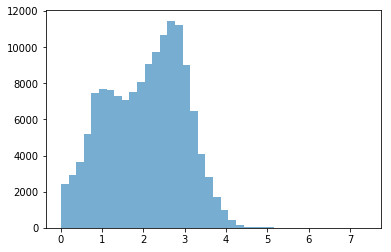

In [80]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.show()

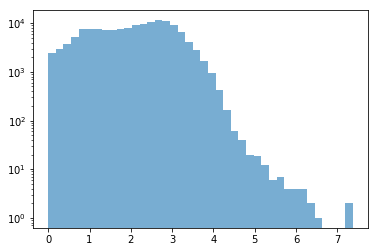

In [81]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Center

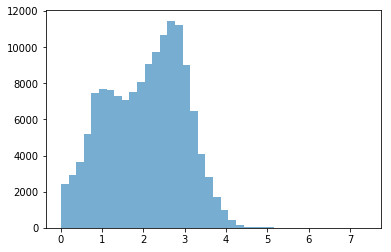

In [82]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.show()

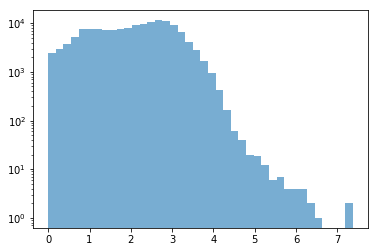

In [83]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input Scale

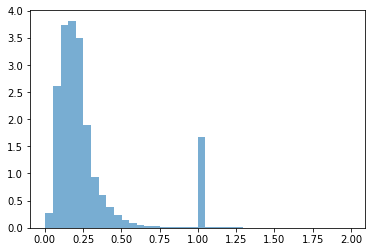

In [84]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

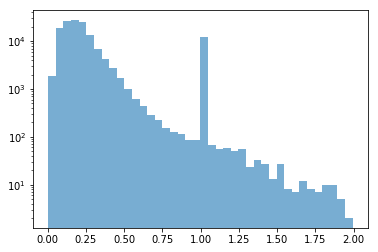

In [85]:
plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Scale

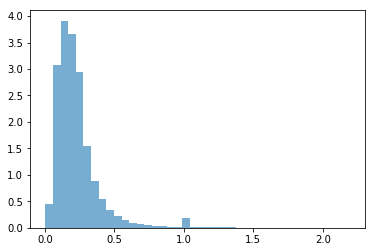

In [86]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

In [87]:
plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [88]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [89]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 0, 0, 0]))

In [90]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[2291, 22088, 41343, 78354, 927, 60]

In [91]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[2291, 22088, 41343, 78354, 927, 60]

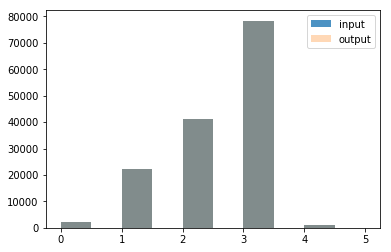

In [92]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

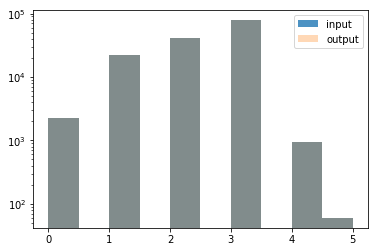

In [93]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

In [94]:
plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

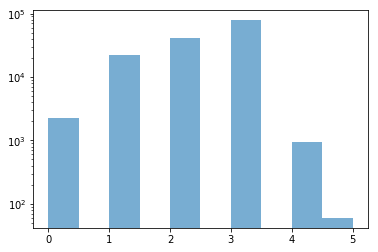

In [95]:
plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [96]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [97]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) No Y_output


#### Original data

In [98]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [99]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

In [100]:
X_train = X_input
Y_train = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

In [101]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

In [102]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

In [103]:
X_input, input_data_norm[:,:x_length]

(array([[ 0.39553021, -1.53088241, -1.53088241, ..., -0.01978233,
         -0.99111679, -0.18810302],
        [-1.12738622, -0.72718657, -0.72718657, ..., -1.45437314,
         -1.85457279, -0.61143914],
        [ 0.75537156, -1.14679044,  0.40930723, ..., -1.14679044,
         -1.14679044, -3.6131469 ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.39553021, -1.53088241, -1.53088241, ..., -0.01978233,
         -0.99111679, -0.18810302],
        [-1.12738622, -0.72718657, -0.72718657, ..., -1.45437314,
         -1.85457279, -0.61143914],
        [ 0.75537156, -1.14679044,  0.40930723, ..., -1.14679044,
         -1.14679044, -3.6131469 ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

In [104]:
Y_input, input_data_norm[:,-y_length:]

(array([[-1.53088241,  0.05784117,  0.13167662, ..., -0.27984787,
         -1.76416271,  0.20207659],
        [-0.72718657, -0.72718657, -1.12738622, ...,  0.32698692,
         -0.50271114, -0.50271114],
        [-0.50095156, -0.50095156, -0.50095156, ..., -2.05704923,
          0.        ,  1.05514611],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-1.53088241,  0.05784117,  0.13167662, ..., -0.27984787,
         -1.76416271,  0.20207659],
        [-0.72718657, -0.72718657, -1.12738622, ...,  0.32698692,
         -0.50271114, -0.50271114],
        [-0.50095156, -0.50095156, -0.50095156, ..., -2.05704923,
          0.        ,  1.05514611],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

In [105]:
X_output, output_data_norm[:,:x_length]

(array([[ 1.68861022, -0.21542364,  0.82579334, ...,  0.06624219,
         -0.02265557,  0.15080171],
        [-0.53531024,  0.16543316, -0.74497626, ...,  1.12286437,
          0.28627452, -0.10833004],
        [-0.73640493,  0.48505753, -1.3209224 , ..., -0.32168318,
          0.        ,  1.846591  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 1.68861022, -0.21542364,  0.82579334, ...,  0.06624219,
         -0.02265557,  0.15080171],
        [-0.53531024,  0.16543316, -0.74497626, ...,  1.12286437,
          0.28627452, -0.10833004],
        [-0.73640493,  0.48505753, -1.3209224 , ..., -0.32168318,
          0.        ,  1.846591  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

In [106]:
if test_length:
    print(Y_output, output_data_norm[:,-y_length:])

In [107]:
X_input_ori, input_data_num

(array([[ 24.,   6.,   6., ...,  18.,   9.,  16.],
        [ 11.,  14.,  14., ...,   9.,   7.,  15.],
        [  6.,   2.,   5., ...,   2.,   2.,   0.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
        [ 11.,  14.,  14., ...,  26.,  16.,  16.],
        [  6.,   2.,   5., ...,   1.,   4.,   7.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]))

In [108]:
Y_input_ori, input_data_num

(array([[  6.,  19.,  20., ...,  15.,   5.,  21.],
        [ 14.,  14.,  11., ...,  26.,  16.,  16.],
        [  3.,   3.,   3., ...,   1.,   4.,   7.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
        [ 11.,  14.,  14., ...,  26.,  16.,  16.],
        [  6.,   2.,   5., ...,   1.,   4.,   7.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]))

In [109]:
X_output_ori, output_data_num

(array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
        [ 15.,  24.,  13., ...,  45.,  26.,  20.],
        [  2.,   6.,   1., ...,   3.,   4.,  17.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
        [ 15.,  24.,  13., ...,  45.,  26.,  20.],
        [  2.,   6.,   1., ...,   3.,   4.,  17.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]))

In [110]:
if test_length:
    print(Y_output_ori, output_data_num)

In [111]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -97.6164222174 188.127540334 -0.34380360635 2.99579278311
(145063, 63) -286.66974431 231.915432237 0.0 3.15308817642
(145063, 63) -110.337503355 8.00100800101 0.0 1.17477179311
(145063, 63) 0.0 21366420.0 88.0 62373.0578871
(145063, 63) 0.0 21580285.0 116.0 63447.5733626
(145063, 63) 0.0 28342885.0 143.0 81329.6278471


#### Min and max cases examination

In [112]:
np.argmax(Y_input, axis=0)

array([11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030,
       11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030,
       11030, 11030, 11030, 11030, 11030, 34790, 34790, 34790, 11030,
       11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030,
       11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030,
       11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030,
       11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030, 11030], dtype=int64)

In [113]:
Y_input[34790]

array([ 122.30376227,  121.34064739,  122.30376227,  123.09231397,
        124.784222  ,  122.46247875,  121.1782942 ,  121.98479746,
        122.93560339,  120.19285402,  122.14453627,  129.26343432,
        128.00415732,  122.93560339,  121.34064739,  121.66376813,
        121.98479746,  121.34064739,  126.71207349,  127.43404923,
        124.17563942,  125.68331956,  121.50247089,  223.01876991,
        231.91543224,  198.8781104 ,  137.1650504 ,  116.04279481,
        115.49874339,   80.01309502,   38.8506997 ,   48.88141723,
         33.43453957,  101.71393638,   91.30401128,   62.26912182,
         67.81384785,   78.88151306,   34.37930828,   48.17787554,
         35.30641672,   34.37930828,   50.25925188,   29.46451271,
         32.47142469,   15.19581058,   16.5547684 ,   24.00859398,
         26.2634758 ,   22.84150819,   12.36081855,   57.80779205,
         37.11021032,  119.18743734,  172.70870457,   31.489237  ,
         43.73321485,   78.11252313,   80.75339022,   47.46421

In [114]:
Y_input_ori[34790]

array([  311.,   305.,   311.,   316.,   327.,   312.,   304.,   309.,
         315.,   298.,   310.,   358.,   349.,   315.,   305.,   307.,
         309.,   305.,   340.,   345.,   323.,   333.,   306.,  2376.,
        2843.,  1460.,   420.,   274.,   271.,   132.,    57.,    70.,
          51.,   205.,   166.,    92.,   103.,   129.,    52.,    69.,
          53.,    52.,    72.,    47.,    50.,    35.,    36.,    42.,
          44.,    41.,    33.,    84.,    55.,   292.,   861.,    49.,
          63.,   127.,   134.,    68.,    50.,    52.,    27.])

In [115]:
fib_median[34790]

25.5

In [118]:
log(Y_input_ori[34790])

array([ 2.49415459,  2.48572143,  2.49415459,  2.50105926,  2.51587384,
        2.49554434,  2.48429984,  2.49136169,  2.49968708,  2.47567119,
        2.49276039,  2.55509445,  2.54406804,  2.49968708,  2.48572143,
        2.48855072,  2.49136169,  2.48572143,  2.53275438,  2.5390761 ,
        2.51054501,  2.52374647,  2.48713838,  3.37602918,  3.45392959,
        3.16465022,  2.6242821 ,  2.43933269,  2.4345689 ,  2.12385164,
        1.76342799,  1.85125835,  1.71600334,  2.31386722,  2.22271647,
        1.96848295,  2.01703334,  2.11394335,  1.72427587,  1.84509804,
        1.73239376,  1.72427587,  1.86332286,  1.68124124,  1.70757018,
        1.5563025 ,  1.56820172,  1.63346846,  1.65321251,  1.62324929,
        1.53147892,  1.92941893,  1.74818803,  2.46686762,  2.93550727,
        1.69897   ,  1.80617997,  2.10720997,  2.13033377,  1.83884909,
        1.70757018,  1.72427587,  1.44715803])

In [119]:
log(fib_median[34790])

1.4232458739368079

In [120]:
np.std(log(Y_input_ori[34790]))

0.4555399839422401

In [121]:
np.std(log(X_input_ori[34790]))

0.0087561388154772067

In [122]:
input_scale[34790]

array([ 0.00875614])

### Split Data into Training and (Pseudo) Cross Validation Sets
Not using this. Use keras built-in feature for pseudo validation

def make_shuffle_index(n, seed=None):
    shuffle_index = np.array(list(range(n)))
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

def using(array_ori, index_list):
    #return np.array([array_ori[i] for i in index_list])
    return np.take(array_ori, index_list, axis=0)

#Generate a shuffle list
shuffle_index = make_shuffle_index(len(X_input), seed=123)

Keep 10% of input data as validation set

#Split the index list into training and validation sets
n_val = int(len(X_input) * 0.1)
val_index = shuffle_index[:n_val]
train_index = shuffle_index[n_val:]

#Split the data sets according to the index list
X_train = using(X_input, train_index)
Y_train = using(Y_input, train_index)
X_val = using(X_input, val_index)
Y_val = using(Y_input, val_index)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

#### Split the untransformed data
Split the untransformed data in the same way for score estimation

train_data_num = using(input_data_num, train_index)
val_data_num = using(input_data_num, val_index)

X_train_ori, Y_train_ori = make_XY(train_data_num)
X_val_ori, Y_val_ori = make_XY(val_data_num)
X_train_ori.shape, Y_train_ori.shape, X_val_ori.shape, Y_val_ori.shape

train_center = using(input_center, train_index)
val_center = using(input_center, val_index)
train_scale = using(input_scale, train_index)
val_scale = using(input_scale, val_index)
train_center.shape, val_center.shape, train_scale.shape, val_scale.shape

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [123]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [124]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [125]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [126]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.nanmean(diff, axis=axis)

In [128]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(109.86142597828301, 146.4244144388739, 0.0)

In [129]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(58.879528613927789, 54.623816383048805)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [130]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape

In [131]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(60, kernel_size=5, activation='relu')(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 60)            360       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3540)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               424920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_

About 22s for 1 epoch on i5-750 CPU

In [132]:
len(gp_list)

6

In [133]:
epochs_list = [40,40,40,40,60,80]

In [134]:
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 2176 samples, validate on 115 samples
Epoch 1/40
1s - loss: 12.2205 - k_smape: 185.7959 - val_loss: 1.3509 - val_k_smape: 193.3739
Epoch 2/40
0s - loss: 10.1583 - k_smape: 187.0477 - val_loss: 0.7942 - val_k_smape: 190.6797
Epoch 3/40
0s - loss: 9.8828 - k_smape: 185.2884 - val_loss: 0.9152 - val_k_smape: 191.5001
Epoch 4/40
0s - loss: 8.7785 - k_smape: 184.2290 - val_loss: 0.8080 - val_k_smape: 191.2023
Epoch 5/40
0s - loss: 7.9030 - k_smape: 184.0617 - val_loss: 0.5441 - val_k_smape: 189.3734
Epoch 6/40
0s - loss: 8.6507 - k_smape: 182.4690 - val_loss: 0.5246 - val_k_smape: 190.5870
Epoch 7/40
0s - loss: 7.6812 - k_smape: 184.3100 - val_loss: 0.5141 - val_k_smape: 189.8404
Epoch 8/40
0s - loss: 7.1903 - k_smape: 182.0426 - val_loss: 0.5287 - val_k_smape: 190.3195
Epoch 9/40
0s - loss: 6.9847 - k_smape: 182.2447 - val_loss: 0.4712 - val_k_smape: 189.9454
Epoch 10/40
0s - loss: 7.2367 - k_smape: 182.1828 - val_loss: 0.5253 - val_k_smape: 190.8205
Epoch 11/40
0s - loss

6s - loss: 3.7356 - k_smape: 116.1109 - val_loss: 1.6333 - val_k_smape: 130.3014
Epoch 9/40
6s - loss: 3.6089 - k_smape: 114.9344 - val_loss: 1.6396 - val_k_smape: 134.0904
Epoch 10/40
6s - loss: 3.6649 - k_smape: 114.8556 - val_loss: 1.7213 - val_k_smape: 139.2284
Epoch 11/40
6s - loss: 3.9165 - k_smape: 115.8186 - val_loss: 1.7018 - val_k_smape: 131.2650
Epoch 12/40
6s - loss: 3.7256 - k_smape: 113.6619 - val_loss: 1.7523 - val_k_smape: 132.6472
Epoch 13/40
6s - loss: 3.5894 - k_smape: 114.2113 - val_loss: 1.6660 - val_k_smape: 131.7137
Epoch 14/40
6s - loss: 3.4693 - k_smape: 112.9455 - val_loss: 1.6590 - val_k_smape: 135.2676
Epoch 15/40
6s - loss: 3.5848 - k_smape: 114.2795 - val_loss: 1.6787 - val_k_smape: 131.1349
Epoch 16/40
6s - loss: 3.4355 - k_smape: 113.1305 - val_loss: 1.7015 - val_k_smape: 134.1878
Epoch 17/40
6s - loss: 3.5200 - k_smape: 113.1260 - val_loss: 1.6363 - val_k_smape: 130.5339
Epoch 18/40
6s - loss: 3.3256 - k_smape: 112.8273 - val_loss: 1.6374 - val_k_smape:

0s - loss: 6.2148 - k_smape: 119.0460 - val_loss: 3.2069 - val_k_smape: 125.6149
Epoch 16/60
0s - loss: 6.0601 - k_smape: 120.3987 - val_loss: 2.8154 - val_k_smape: 119.9272
Epoch 17/60
0s - loss: 6.1856 - k_smape: 119.4718 - val_loss: 2.8666 - val_k_smape: 119.9930
Epoch 18/60
0s - loss: 6.3497 - k_smape: 118.2524 - val_loss: 4.3906 - val_k_smape: 128.2840
Epoch 19/60
0s - loss: 6.6279 - k_smape: 114.0486 - val_loss: 3.0706 - val_k_smape: 119.0602
Epoch 20/60
0s - loss: 5.9606 - k_smape: 114.2413 - val_loss: 2.7661 - val_k_smape: 115.4799
Epoch 21/60
0s - loss: 6.3527 - k_smape: 114.3683 - val_loss: 2.7549 - val_k_smape: 115.0058
Epoch 22/60
0s - loss: 5.9084 - k_smape: 108.7561 - val_loss: 4.2669 - val_k_smape: 122.1376
Epoch 23/60
0s - loss: 6.2729 - k_smape: 110.1175 - val_loss: 2.6378 - val_k_smape: 110.1468
Epoch 24/60
0s - loss: 5.5434 - k_smape: 108.0545 - val_loss: 3.3217 - val_k_smape: 114.0765
Epoch 25/60
0s - loss: 5.5267 - k_smape: 104.0806 - val_loss: 2.5392 - val_k_smape

0s - loss: 50.6369 - k_smape: 92.5078 - val_loss: 0.8956 - val_k_smape: 101.4138
Epoch 44/80
0s - loss: 42.0220 - k_smape: 90.6996 - val_loss: 0.9311 - val_k_smape: 103.0977
Epoch 45/80
0s - loss: 43.3245 - k_smape: 93.3460 - val_loss: 0.9349 - val_k_smape: 102.9928
Epoch 46/80
0s - loss: 40.1542 - k_smape: 92.1134 - val_loss: 0.9241 - val_k_smape: 102.2766
Epoch 47/80
0s - loss: 47.6553 - k_smape: 91.4227 - val_loss: 0.8987 - val_k_smape: 101.0146
Epoch 48/80
0s - loss: 35.5886 - k_smape: 89.3783 - val_loss: 0.8648 - val_k_smape: 99.5104
Epoch 49/80
0s - loss: 49.4268 - k_smape: 90.1594 - val_loss: 0.8142 - val_k_smape: 97.6233
Epoch 50/80
0s - loss: 37.5731 - k_smape: 88.5866 - val_loss: 0.7692 - val_k_smape: 95.5089
Epoch 51/80
0s - loss: 56.9977 - k_smape: 86.8148 - val_loss: 0.7489 - val_k_smape: 93.4928
Epoch 52/80
0s - loss: 38.9256 - k_smape: 84.0059 - val_loss: 0.7409 - val_k_smape: 92.4943
Epoch 53/80
0s - loss: 52.8488 - k_smape: 86.7753 - val_loss: 0.7409 - val_k_smape: 92.

### Training History

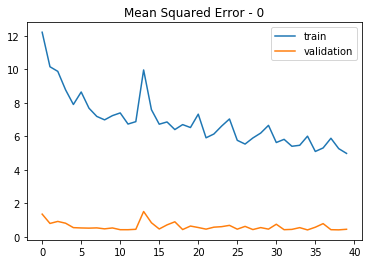

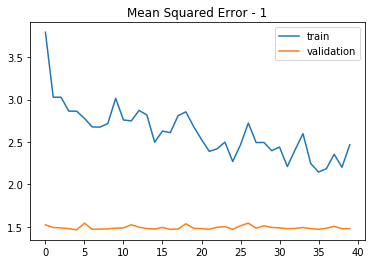

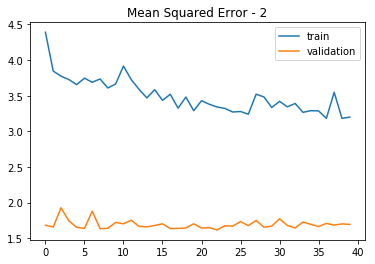

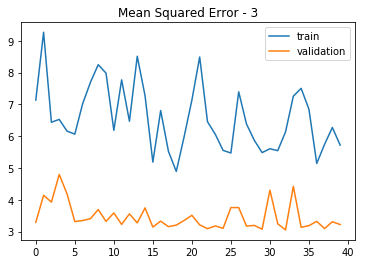

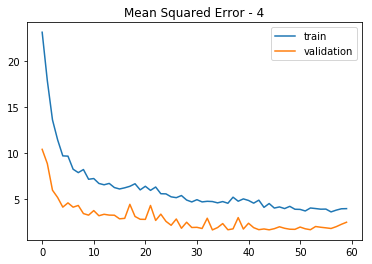

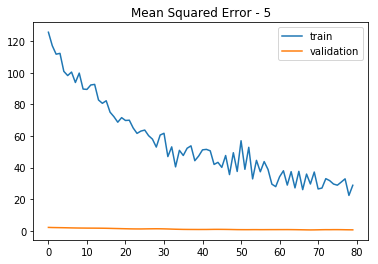

In [135]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Mean Squared Error - ' + str(gp))
    plt.legend(); plt.show()

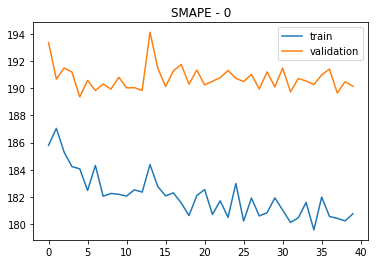

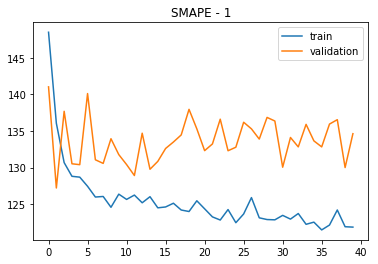

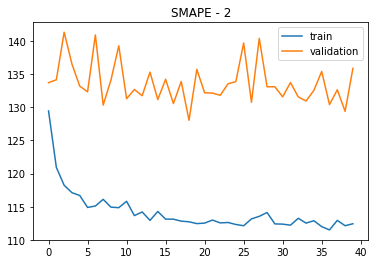

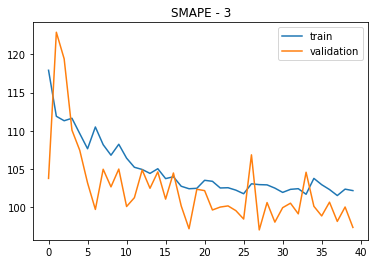

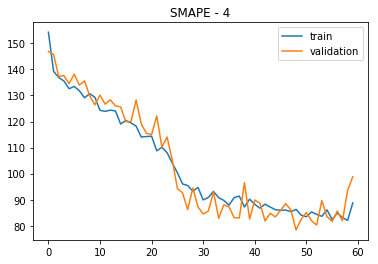

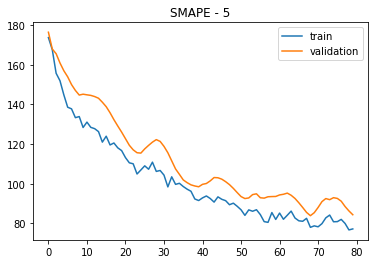

In [136]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label='train')
    plt.plot(hist.history['val_k_smape'], label='validation')
    plt.title('SMAPE - ' + str(gp))
    plt.legend(); plt.show()

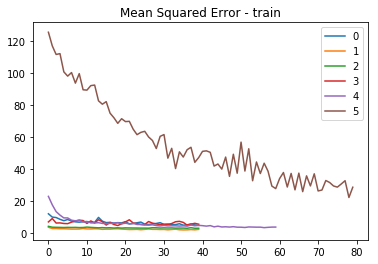

In [137]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

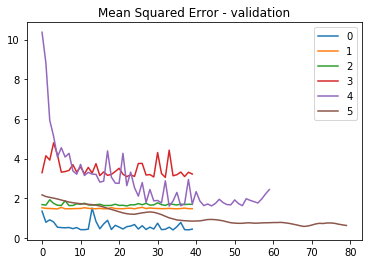

In [138]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

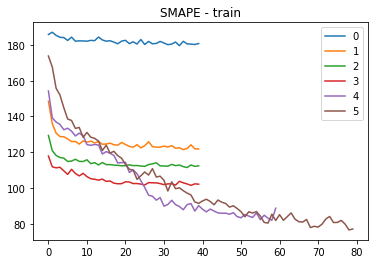

In [139]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

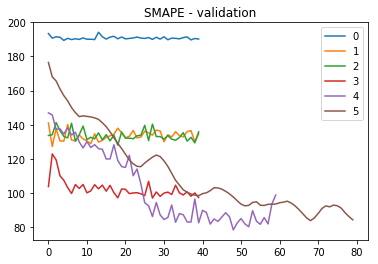

In [140]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using for Output Set

In [141]:
if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [142]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [145]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [146]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [147]:
for o in output_index_list:
    print(o.shape)

(2291,)
(22088,)
(41343,)
(78354,)
(927,)
(60,)


In [148]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([    54,    117,    148, ..., 123025, 139119, 140151])

In [149]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [150]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [151]:
# Inverse transform Y of output
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [152]:
Y_output_pred

array([[ 0.69725996,  0.7194401 ,  0.77077085, ...,  0.8836419 ,
         0.9235608 ,  0.99866849],
       [ 0.09057308,  0.16450301,  0.18186194, ...,  0.19587258,
         0.23776841,  0.27868074],
       [-0.15142943, -0.03948647,  0.09105905, ...,  0.10397337,
         0.23297147,  0.19535717],
       ..., 
       [ 0.11207306,  0.09500711,  0.13461362, ...,  0.12037959,
         0.08292598,  0.09531644],
       [ 0.11207306,  0.09500711,  0.13461362, ...,  0.12037959,
         0.08292598,  0.09531644],
       [ 0.11207306,  0.09500711,  0.13461362, ...,  0.12037959,
         0.08292598,  0.09531644]], dtype=float32)

In [153]:
Y_output_pred_ori

array([[ 27.78413806,  28.1548779 ,  29.03128481, ...,  31.05218505,
         31.79900707,  33.25165142],
       [ 22.83605113,  23.98519457,  24.26295084, ...,  24.48938209,
         25.17865689,  25.86973509],
       [  3.50142996,   3.86490477,   4.32601494, ...,   4.37394155,
          4.87698796,   4.72562826],
       ..., 
       [  0.29441359,   0.24453498,   0.36336964, ...,   0.31940945,
          0.21039181,   0.24542173],
       [  0.29441359,   0.24453498,   0.36336964, ...,   0.31940945,
          0.21039181,   0.24542173],
       [  0.29441359,   0.24453498,   0.36336964, ...,   0.31940945,
          0.21039181,   0.24542173]])

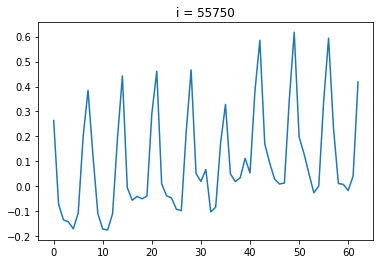

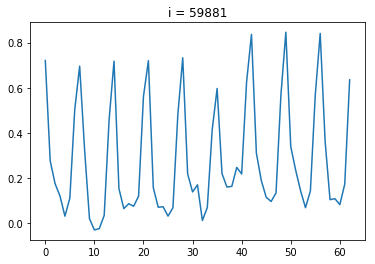

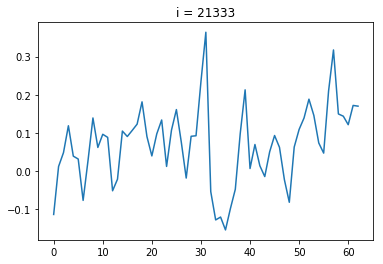

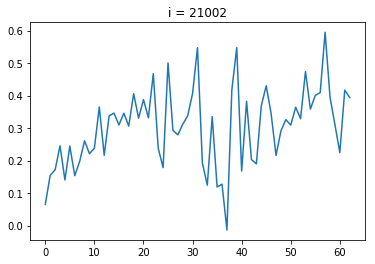

array([ 55750,  59881,  21333,  21002, 126766])

In [154]:
examine(Y_output_pred)

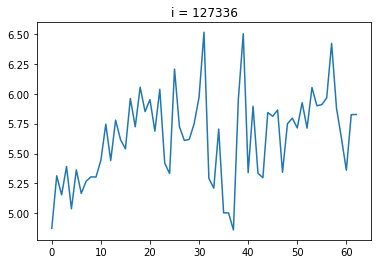

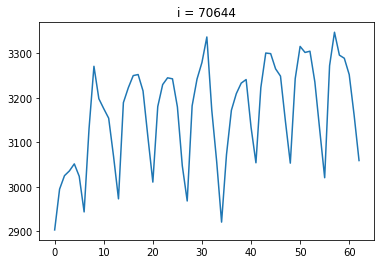

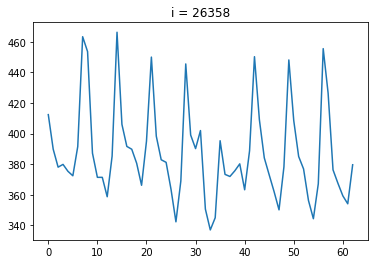

array([127336,  70644, 126420,  82294,  26358])

In [155]:
examine(Y_output_pred_ori)

In [157]:
view(X_output_ori[126420])

## Self-Testing

In [158]:
# SMAPE assuming nan == 0
if test_length: 
    smape(Y_output_ori, Y_output_pred_ori)

In [159]:
# SMAPE score excluding nan (Correct one)
if test_length: 
    smape(Y_output_raw, Y_output_pred_ori)

In [161]:
model_name

'model_7_CNN_with_Fibo_1_range_correct_1_smape_correct'

In [163]:
epochs_list#, epochs_list2

[40, 40, 40, 40, 60, 80]

SMAPE:

50.523 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.516 - Model 6.0.1 CNN - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.686 - Model 6.3.0 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.265 - Model 6.3.1 - (40,40,40,60,60) epoches

50.289 - Model 6.3.1 - (40,40,40,60,60) epoches, run 2

51.017 - Model 6.3.2 - (20,40,20,80,80) epoches

50.773 - Model 6.3.3 group by scale (= 0.,< 1.4,< 2.5,< 3.8,) - (20,30,20,20,30) epoches

50.434 - Model 6.3.4 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,60,60) epoches

50.283 - Model 6.3.5 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.923 - Model 6.3.6 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.895 - Model 6.3.7 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

48.371 - Model 7.0.0 Fibonacci - group(= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

49.392 - Model 7.1.0 Fibonacci - range corrected :-y_length

47.657 - Model 7.00 Original Fibonacci median without neural network

48.159 - Model 49 days median

Correct SMAPE:

45.879 - Model 7.00 Original Fibonacci median without neural network

46.461 - Model 7.00.1 Original Fibonacci median without neural network with nan replaced by 0

46.998 - Model 49 days median

47.701 - Model 49 days median with nan replaced by 0

45.248 - Model 7.1.1 CNN Fibonacci - range corrected :-y_length - score corrected

## Group Scores
For self-testing stage only

Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]  # The one including nan

for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
    print(smape(Y, Y_p), len(Y))

# The actual score with nan
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    print(smape(Y, Y_p), len(Y))

tot_n = len(output_gp); tot_n

tot_n = len(output_gp)
x_tmp = 0.
for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * len(Y)
    print(s_tmp / tot_n)
    x_tmp += s_tmp
x_tmp / tot_n

def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

count_not_nan(Y_output_raw)

# the correct one (excluding nan)
n_not_nan = count_not_nan(Y_output_raw)
x_tmp = 0.
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * count_not_nan(Y)
    print(s_tmp / n_not_nan)
    x_tmp += s_tmp
x_tmp / n_not_nan

Filter size| 3| 5| 7| Fib 5
-|-|-|-|-
0| 7.539| 7.590	| 7.582| 3.010
1| 9.722| 9.855	| 9.776|11.571
2|12.666|12.886	|13.033|12.167
3|20.117|20.323	|20.295|21.287
4| 0.225| 0.226	| 0.223| 0.321
5| 0.015| 0.014	| 0.014| 0.014
Total| 50.283| 50.895| 50.922| 48.371

## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [164]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True):
    for x in x_list:
        plt.plot(x)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i))
    return list(view_list)

view_list = None

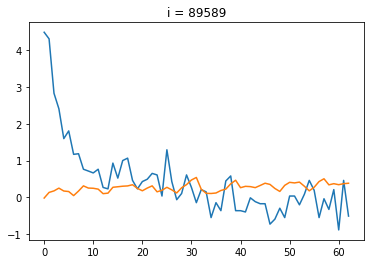

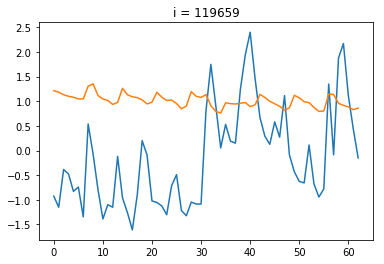

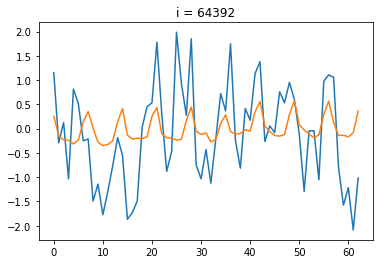

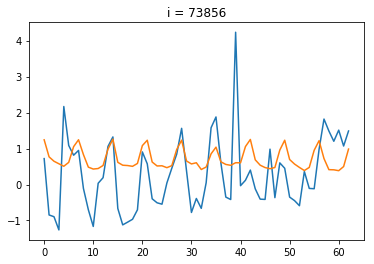

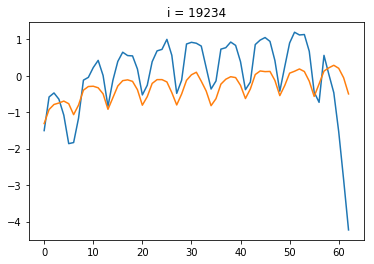

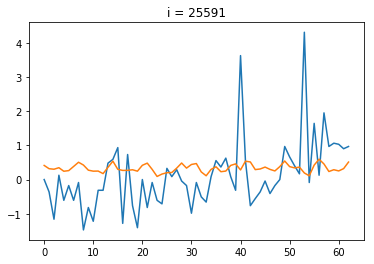

In [165]:
view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [166]:
view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

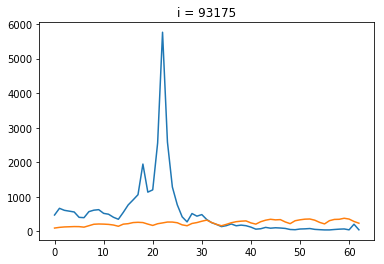

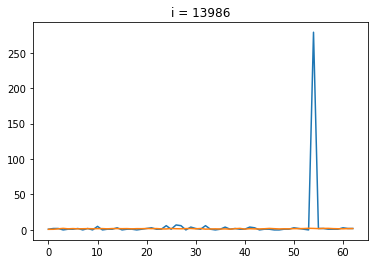

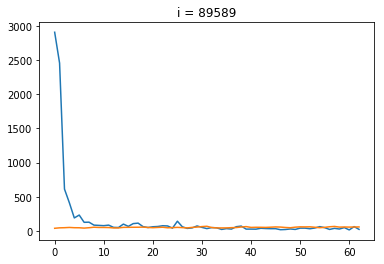

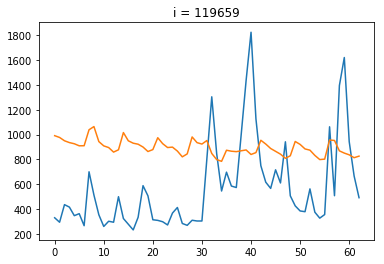

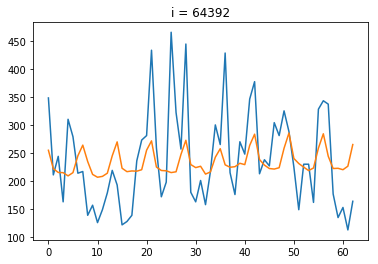

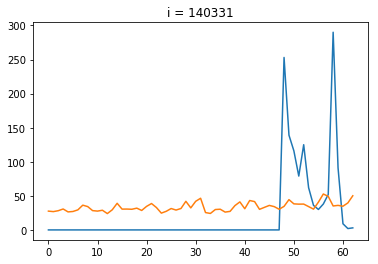

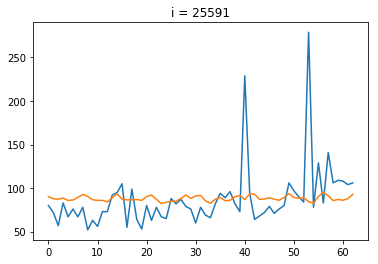

In [167]:
view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

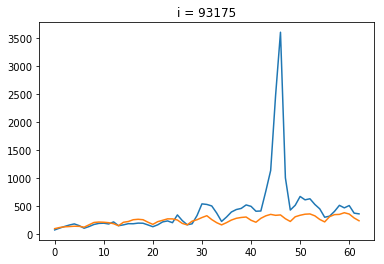

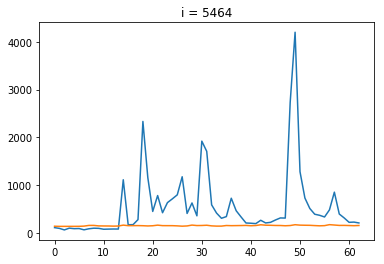

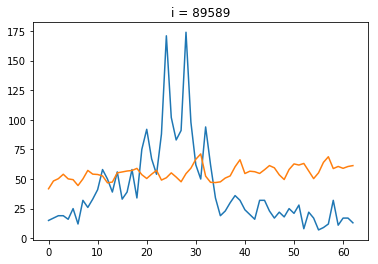

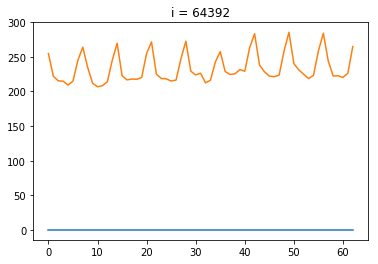

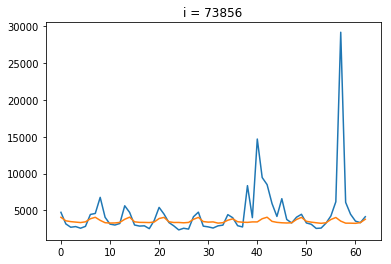

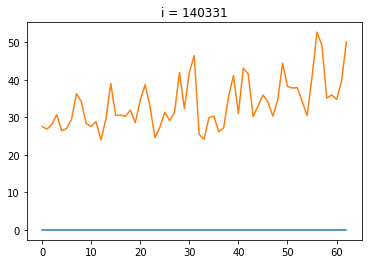

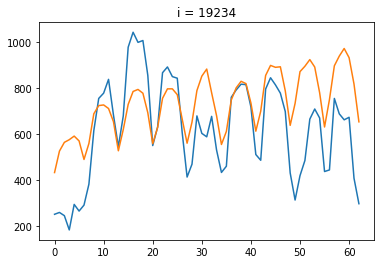

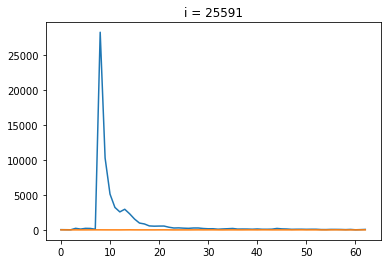

In [168]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

In [172]:
if test_length:
    view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

In [173]:
if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output),
                             view_list=view_list)

In [174]:
if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
                             view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

#### Case 41896

In [175]:
i = 41896

In [180]:
multi_view((X_input[i], Y_input[i]))

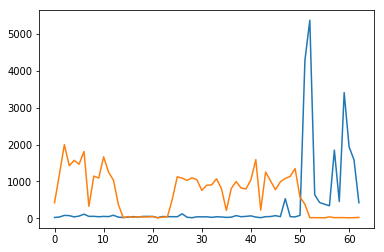

In [177]:
comp_view(X_input_ori[i], Y_input_ori[i])

In [184]:
comp_view(X_output_ori[i], Y_output_pred_ori[i])

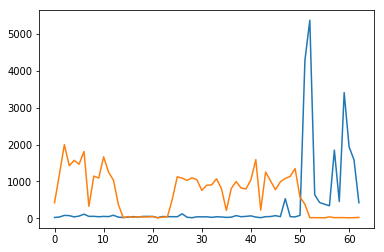

In [185]:
comp_view(X_input_ori[i], Y_input_ori[i])

In [186]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 3.25779853]),
 array([ 3.25779853]),
 array([ 0.59788697]),
 array([ 0.51907988]))

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [192]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [189]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_pred_ori, columns = Y_output_dates)
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        27.784138   28.154878   29.031285   30.195806   29.291119   
1        22.836051   23.985195   24.262951   25.104532   23.612299   
2         3.501430    3.864905    4.326015    4.654355    4.195273   
3        16.335367   15.260377   15.172442   15.614767   14.847325   
4        12.643578   13.590496   13.755696   14.229975   13.350333   
5        29.246258   24.369767   23.993174   24.765036   23.350155   
6         7.225726    7.597032    7.838625    8.145117    7.514947   
7        47.694680   46.585746   47.490783   50.014712   47.466674   
8        44.757532   42.583918   41.819758   42.910249   40.733860   
9        37.485755   40.393126   41.228786   41.864686   41.137077   
10       22.263217   23.390687   24.104824   25.684807   24.475953   
11       21.302575   21.621908   22.173830   23.061593   22.188918   
12        3.542640    3.735086    3.867221    4.027687    3.754983   
13       14.680146   15.533421   15.768387   16.410961   15.976877   
14       43.064085   47.136410   48.233163   50.159936   48.829619   
15       55.889756   62.823142   64.117086   64.656373   62.179289   
16       31.804632   32.083506   32.277519   34.142916   32.042794   
17        8.377070    8.783813    8.834126    9.335598    8.713158   
18       16.915877   17.217330   17.386580   17.943127   17.293395   
19        7.603102    7.989280    8.413551    8.826970    8.116780   
20       53.378733   68.325866   71.504740   76.000704   72.438540   
21       18.998670   20.117450   20.331636   21.350577   21.130723   
22       17.864792   21.057130   21.899299   22.827570   22.257051   
23       44.602260   46.167849   46.634011   48.107889   46.212496   
24       80.808624   86.155120   88.968067   94.549521   89.164048   
25       17.246171   16.602752   16.528405   17.032078   16.361045   
26       37.637605   43.206625   44.392667   46.890026   44.379069   
27       10.366338   11.357522   11.644404   12.130706   11.729640   
28       37.921617   35.971198   34.988929   34.683162   33.149482   
29       11.469837   11.703169   11.784931   12.249260   11.659701   
...            ...         ...         ...         ...         ...   
145033   35.106739   36.816897   37.247247   39.062435   37.328305   
145034    8.654212    9.039151    9.313590   10.531779    9.674454   
145035    6.007874    6.813376    7.067889    7.950649    6.688619   
145036    1.344890    1.429399    1.629596    1.738823    1.520473   
145037    3.721749    3.921245    4.336470    4.521855    4.113959   
145038   15.118356   16.900235   17.434364   18.405948   17.625310   
145039   16.035351   17.416511   17.785592   18.883089   17.804332   
145040    1.683008    1.845058    1.957288    2.101371    1.847747   
145041    6.609915    6.805051    6.862572    7.369008    6.789875   
145042    1.789718    2.055862    2.063401    2.338830    1.996374   
145043    6.200514    6.495669    6.897179    7.178838    6.541197   
145044   32.313654   35.302136   36.676286   40.206369   37.055762   
145045    0.908343    1.005318    1.055367    1.146901    0.978574   
145046    6.663804    6.793253    6.988534    7.195349    6.810384   
145047    2.047697    2.558373    1.996556    2.244176    1.766848   
145048    3.679243    4.045794    4.391954    4.780006    4.090771   
145049    7.379841    8.390383    7.813407    7.737371    7.011016   
145050    1.666520    1.907820    2.076990    2.327531    1.925926   
145051    8.433151   10.723435   11.404214   13.290801   11.855260   
145052   11.608676   11.354912   11.250390   12.760887   11.887116   
145053    4.186972    4.647074    4.648205    4.979127    4.400600   
145054    9.647160   10.157535   10.331735   11.355221   10.188365   
145055    2.036015    2.437906    2.370796    2.502596    2.279133   
145056   28.158966   37.105732   37.355228   42.032798   35.729464   
145057    1.282542    8.007699    6.072383    2.088758    4.717315   
145058   13.506191

In [190]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        27.784138   28.154878   29.031285   30.195806   29.291119   
1        22.836051   23.985195   24.262951   25.104532   23.612299   
2         3.501430    3.864905    4.326015    4.654355    4.195273   
3        16.335367   15.260377   15.172442   15.614767   14.847325   
4        12.643578   13.590496   13.755696   14.229975   13.350333   
5        29.246258   24.369767   23.993174   24.765036   23.350155   
6         7.225726    7.597032    7.838625    8.145117    7.514947   
7        47.694680   46.585746   47.490783   50.014712   47.466674   
8        44.757532   42.583918   41.819758   42.910249   40.733860   
9        37.485755   40.393126   41.228786   41.864686   41.137077   
10       22.263217   23.390687   24.104824   25.684807   24.475953   
11       21.302575   21.621908   22.173830   23.061593   22.188918   
12        3.542640    3.735086    3.867221    4.027687    3.754983   
13       14.680146   15.533421   15.768387   16.410961   15.976877   
14       43.064085   47.136410   48.233163   50.159936   48.829619   
15       55.889756   62.823142   64.117086   64.656373   62.179289   
16       31.804632   32.083506   32.277519   34.142916   32.042794   
17        8.377070    8.783813    8.834126    9.335598    8.713158   
18       16.915877   17.217330   17.386580   17.943127   17.293395   
19        7.603102    7.989280    8.413551    8.826970    8.116780   
20       53.378733   68.325866   71.504740   76.000704   72.438540   
21       18.998670   20.117450   20.331636   21.350577   21.130723   
22       17.864792   21.057130   21.899299   22.827570   22.257051   
23       44.602260   46.167849   46.634011   48.107889   46.212496   
24       80.808624   86.155120   88.968067   94.549521   89.164048   
25       17.246171   16.602752   16.528405   17.032078   16.361045   
26       37.637605   43.206625   44.392667   46.890026   44.379069   
27       10.366338   11.357522   11.644404   12.130706   11.729640   
28       37.921617   35.971198   34.988929   34.683162   33.149482   
29       11.469837   11.703169   11.784931   12.249260   11.659701   
...            ...         ...         ...         ...         ...   
145033   35.106739   36.816897   37.247247   39.062435   37.328305   
145034    8.654212    9.039151    9.313590   10.531779    9.674454   
145035    6.007874    6.813376    7.067889    7.950649    6.688619   
145036    1.344890    1.429399    1.629596    1.738823    1.520473   
145037    3.721749    3.921245    4.336470    4.521855    4.113959   
145038   15.118356   16.900235   17.434364   18.405948   17.625310   
145039   16.035351   17.416511   17.785592   18.883089   17.804332   
145040    1.683008    1.845058    1.957288    2.101371    1.847747   
145041    6.609915    6.805051    6.862572    7.369008    6.789875   
145042    1.789718    2.055862    2.063401    2.338830    1.996374   
145043    6.200514    6.495669    6.897179    7.178838    6.541197   
145044   32.313654   35.302136   36.676286   40.206369   37.055762   
145045    0.908343    1.005318    1.055367    1.146901    0.978574   
145046    6.663804    6.793253    6.988534    7.195349    6.810384   
145047    2.047697    2.558373    1.996556    2.244176    1.766848   
145048    3.679243    4.045794    4.391954    4.780006    4.090771   
145049    7.379841    8.390383    7.813407    7.737371    7.011016   
145050    1.666520    1.907820    2.076990    2.327531    1.925926   
145051    8.433151   10.723435   11.404214   13.290801   11.855260   
145052   11.608676   11.354912   11.250390   12.760887   11.887116   
145053    4.186972    4.647074    4.648205    4.979127    4.400600   
145054    9.647160   10.157535   10.331735   11.355221   10.188365   
145055    2.036015    2.437906    2.370796    2.502596    2.279133   
145056   28.158966   37.105732   37.355228   42.032798   35.729464   
145057    1.282542    8.007699    6.072383    2.088758    4.717315   
145058   13.506191

In [191]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

Page        date  \
0                  2NE1_zh.wikipedia.org_all-access_spider  2017-01-01   
1                   2PM_zh.wikipedia.org_all-access_spider  2017-01-01   
2                    3C_zh.wikipedia.org_all-access_spider  2017-01-01   
3               4minute_zh.wikipedia.org_all-access_spider  2017-01-01   
4        52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  2017-01-01   
5                  5566_zh.wikipedia.org_all-access_spider  2017-01-01   
6                91Days_zh.wikipedia.org_all-access_spider  2017-01-01   
7                 A'N'D_zh.wikipedia.org_all-access_spider  2017-01-01   
8                 AKB48_zh.wikipedia.org_all-access_spider  2017-01-01   
9                 ASCII_zh.wikipedia.org_all-access_spider  2017-01-01   
10                ASTRO_zh.wikipedia.org_all-access_spider  2017-01-01   
11       Ahq_e-Sports_Club_zh.wikipedia.org_all-access_...  2017-01-01   
12       All_your_base_are_belong_to_us_zh.wikipedia.or...  2017-01-01   
13              AlphaGo_zh.wikipedia.org_all-access_spider  2017-01-01   
14              Android_zh.wikipedia.org_all-access_spider  2017-01-01   
15           Angelababy_zh.wikipedia.org_all-access_spider  2017-01-01   
16                Apink_zh.wikipedia.org_all-access_spider  2017-01-01   
17             Apple_II_zh.wikipedia.org_all-access_spider  2017-01-01   
18               As_One_zh.wikipedia.org_all-access_spider  2017-01-01   
19            B-PROJECT_zh.wikipedia.org_all-access_spider  2017-01-01   
20                 B1A4_zh.wikipedia.org_all-access_spider  2017-01-01   
21                 BDSM_zh.wikipedia.org_all-access_spider  2017-01-01   
22                BEAST_zh.wikipedia.org_all-access_spider  2017-01-01   
23              BIGBANG_zh.wikipedia.org_all-access_spider  2017-01-01   
24           BLACK_PINK_zh.wikipedia.org_all-access_spider  2017-01-01   
25               BLEACH_zh.wikipedia.org_all-access_spider  2017-01-01   
26                 BTOB_zh.wikipedia.org_all-access_spider  2017-01-01   
27       Beautiful_Mind_zh.wikipedia.org_all-access_spider  2017-01-01   
28               Beyond_zh.wikipedia.org_all-access_spider  2017-01-01   
29                  Big_zh.wikipedia.org_all-access_spider  2017-01-01   
...                                                    ...         ...   
9138939  Sin_senos_sí_hay_paraíso_es.wikipedia.org_all-...  2017-03-04   
9138940  Anexo:Medallero_de_los_Juegos_Olímpicos_de_Río...  2017-03-04   
9138941  Arrival_(película)_es.wikipedia.org_all-access...  2017-03-04   
9138942  Anexo:Baloncesto_en_los_Juegos_Olímpicos_de_Rí...  2017-03-04   
9138943  Hasta_que_te_conocí_(serie_de_televisión)_es.w...  2017-03-04   
9138944  Westworld_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138945        Milénico_es.wikipedia.org_all-access_spider  2017-03-04   
9138946  Moonlight_(película)_es.wikipedia.org_all-acce...  2017-03-04   
9138947  Sully_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138948  Pulsaciones_(serie_de_televisión)_es.wikipedia...  2017-03-04   
9138949  2091_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138950  Campeonato_Sudamericano_de_Fútbol_Sub-20_de_20...  2017-03-04   
9138951  Split_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138952  Huracán_Matthew_es.wikipedia.org_all-access_sp...  2017-03-04   
9138953  Fences_(película)_es.wikipedia.org_all-access_...  2017-03-04   
9138954  Logan_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138955  La_doña_(telenovela_de_2016)_es.wikipedia.org_...  2017-03-04   
9138956  RTS_(canal_de_televisión)_es.wikipedia.org_all...  2017-03-04   
9138957  La_ley_del_corazón_es.wikipedia.org_all-access...  2017-03-04   
9138958  The_Crown_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138959  Drake_(músico)_es.wikipedia.org_all-access_spider  2017-03-04   
9138960  Skam_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138961  Legión_(serie_de_televisión)_es.wikipedia.org_...

### Output DataFrame

In [197]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

%%% Reading data key_1.csv ...done!


In [198]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

Page            Id        date
0  !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af  2017-01-01
1  !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9  2017-01-02
2  !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c  2017-01-03
3  !vote_en.wikipedia.org_all-access_all-agents  e98873359be6  2017-01-04
4  !vote_en.wikipedia.org_all-access_all-agents  fa012434263a  2017-01-05

In [199]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703780 entries, 0 to 8703779
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 199.2+ MB


In [200]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

array(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
       '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
       '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
       '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
       '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
       '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
       '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
       '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
       '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
       '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
       '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-01-01', '2017-01-02'], dtype=object)

In [201]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [202]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

Page            Id  \
0        !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af   
1        !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9   
2        !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c   
3        !vote_en.wikipedia.org_all-access_all-agents  e98873359be6   
4        !vote_en.wikipedia.org_all-access_all-agents  fa012434263a   
5        !vote_en.wikipedia.org_all-access_all-agents  48f1e93517a2   
6        !vote_en.wikipedia.org_all-access_all-agents  5def418fcb36   
7        !vote_en.wikipedia.org_all-access_all-agents  77bd08134351   
8        !vote_en.wikipedia.org_all-access_all-agents  5889e6dbb16f   
9        !vote_en.wikipedia.org_all-access_all-agents  5f21fef1d764   
10       !vote_en.wikipedia.org_all-access_all-agents  6f07e1b8815a   
11       !vote_en.wikipedia.org_all-access_all-agents  228e54b5dea0   
12       !vote_en.wikipedia.org_all-access_all-agents  da1b34963ed7   
13       !vote_en.wikipedia.org_all-access_all-agents  ab5ccefaa2db   
14       !vote_en.wikipedia.org_all-access_all-agents  cbf42873ebf1   
15       !vote_en.wikipedia.org_all-access_all-agents  ac67e35ed44e   
16       !vote_en.wikipedia.org_all-access_all-agents  88c098aa640d   
17       !vote_en.wikipedia.org_all-access_all-agents  7c72842a89d1   
18       !vote_en.wikipedia.org_all-access_all-agents  8ce002f2c329   
19       !vote_en.wikipedia.org_all-access_all-agents  5f72d9920560   
20       !vote_en.wikipedia.org_all-access_all-agents  f93afd7f5d9b   
21       !vote_en.wikipedia.org_all-access_all-agents  14011cb66f2d   
22       !vote_en.wikipedia.org_all-access_all-agents  0065551ac465   
23       !vote_en.wikipedia.org_all-access_all-agents  175f1872729e   
24       !vote_en.wikipedia.org_all-access_all-agents  31d756e83124   
25       !vote_en.wikipedia.org_all-access_all-agents  e186c2363c5e   
26       !vote_en.wikipedia.org_all-access_all-agents  3bce56c2b977   
27       !vote_en.wikipedia.org_all-access_all-agents  d497981dce77   
28       !vote_en.wikipedia.org_all-access_all-agents  c813cec10548   
29       !vote_en.wikipedia.org_all-access_all-agents  5123e0ed62c9   
...                                               ...           ...   
8703750   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1fb8f902ad0f   
8703751   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0107f6d7cd82   
8703752   龙生九子_zh.wikipedia.org_mobile-web_all-agents  30c402ed9e49   
8703753   龙生九子_zh.wikipedia.org_mobile-web_all-agents  935fa0168d01   
8703754   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1140b428380e   
8703755   龙生九子_zh.wikipedia.org_mobile-web_all-agents  cc5eadae0d7a   
8703756   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f923701cdb05   
8703757   龙生九子_zh.wikipedia.org_mobile-web_all-agents  905679a20d39   
8703758   龙生九子_zh.wikipedia.org_mobile-web_all-agents  642354a50690   
8703759   龙生九子_zh.wikipedia.org_mobile-web_all-agents  7376c63bd4c1   
8703760   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1f0566b71f7e   
8703761   龙生九子_zh.wikipedia.org_mobile-web_all-agents  938774bbb675   
8703762   龙生九子_zh.wikipedia.org_mobile-web_all-agents  53c046bac8cb   
8703763   龙生九子_zh.wikipedia.org_mobile-web_all-agents  ead2377353d3   
8703764   龙生九子_zh.wikipedia.org_mobile-web_all-agents  efa87c7d5160   
8703765   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f239d6ceb17b   
8703766   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0fef0826b1bc   
8703767   龙生九子_zh.wikipedia.org_mobile-web_all-agents  478d3c34b0c1   
8703768   龙生九子_zh.wikipedia.org_mobile-web_all-agents  6a1b6e3028fc   
8703769   龙生九子_zh.wikipedia.org_mobile-web_all-agents  3b5fb022accd   
8703770   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a4456a9d271d   
8703771   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d43a25cf4ef2   
8703772   龙生九子_zh.wikipedia.org_mobile-web_all-agents  8f47d2e020cd   
8703773   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a78af728d84b   
8703774   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d1ba45c7ec08   
87

In [205]:
del result_flat_df

In [206]:
gc.collect()

10485

In [203]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float64)

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [204]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                + '.csv', index = False)
print('done!')

%%% Writing result for model_7_CNN_with_Fibo_1_range_correct_2_predict ...done!


Kaggle Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]